In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Get data

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

In [3]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=",")
  next(reader)
  for row in reader:
    temps.append(float(row[1]))

time_step = [i for i in range(1,len(temps)+1)]

Preprocess

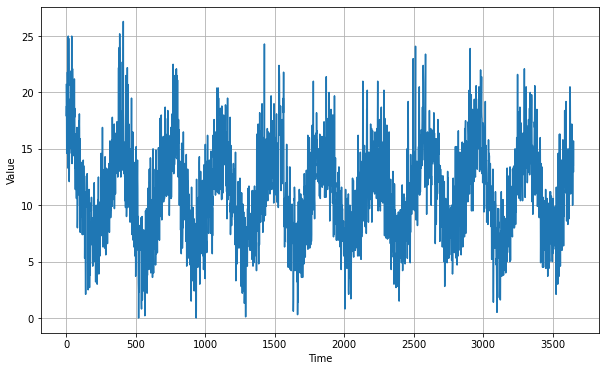

In [4]:
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
     

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Model with dynamic lr scheduler, to find the optimum one

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


10/10 [==============================] - 15s 366ms/step - loss: 31.1571 - mae: 31.6550 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 4s 323ms/step - loss: 30.5778 - mae: 31.0756 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 3s 320ms/step - loss: 29.6825 - mae: 30.1801 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 4s 323ms/step - loss: 28.5613 - mae: 29.0586 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 4s 318ms/step - loss: 27.1974 - mae: 27.6945 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 3s 317ms/step - loss: 25.5017 - mae: 25.9986 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 4s 324ms/step - loss: 23.3464 - mae: 23.8429 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 4s 322ms/step - loss: 20.6147 - mae: 21.1108 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 4s 317ms/step - loss: 17.3142 - mae: 1

Plot to find optimum learning rate

(1e-08, 0.0001, 0.0, 60.0)

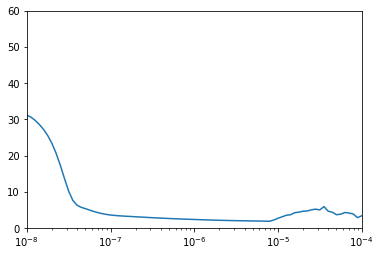

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Re-train with updated layers and learning rate




In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)

Epoch 1/30
25/25 [==============================] - 9s 187ms/step - loss: 8.7533 - mae: 9.2427
Epoch 2/30
25/25 [==============================] - 5s 185ms/step - loss: 4.5117 - mae: 4.9943
Epoch 3/30
25/25 [==============================] - 5s 186ms/step - loss: 4.1193 - mae: 4.6038
Epoch 4/30
25/25 [==============================] - 5s 188ms/step - loss: 2.9113 - mae: 3.3835
Epoch 5/30
25/25 [==============================] - 5s 185ms/step - loss: 2.1947 - mae: 2.6537
Epoch 6/30
25/25 [==============================] - 5s 186ms/step - loss: 1.8132 - mae: 2.2639
Epoch 7/30
25/25 [==============================] - 5s 187ms/step - loss: 1.7232 - mae: 2.1715
Epoch 8/30
25/25 [==============================] - 5s 188ms/step - loss: 1.6878 - mae: 2.1350
Epoch 9/30
25/25 [==============================] - 5s 186ms/step - loss: 1.6804 - mae: 2.1273
Epoch 10/30
25/25 [==============================] - 5s 186ms/step - loss: 1.6497 - mae: 2.0951
Epoch 11/30
25/25 [==============================

Forecast and then plot real data and forecast

113/113 [==============================] - 4s 25ms/step


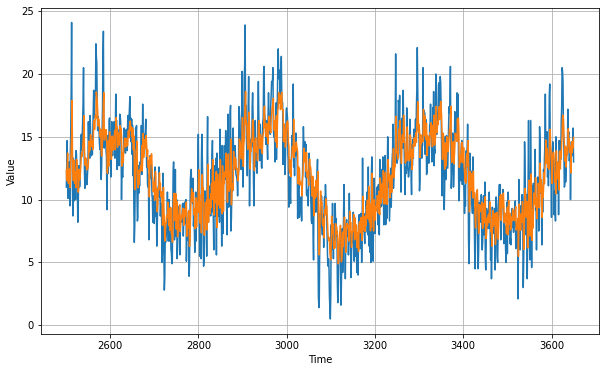

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
     

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


1.8079554

In [12]:
print(rnn_forecast)


[12.335345 11.526741 12.753052 ... 14.184925 14.153382 14.946922]
